In [ ]:
# connet google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/PhD/Hand/Data/'

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import random
from tqdm import tqdm
from os import X_OK
from numpy import array
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
data = np.load(path + 'combData.npy')
Y = np.load(path + 'label.npy')

In [ ]:
# split training and test data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=10, stratify=Y)

In [ ]:
# only use one time and one variable 
def OneVar1Exp(x, y, one2x, smp_fqc, n_time, n_var):
  '''
  this function is used to convert original 4d data to 2d format to train
  x: input 4d data
  one2x: split one instance to x "instances" to increase training data set
  smp_fqc: the sample fequency for each sequence
  n_time: the number of experiment to be sample
  n_var: which variable should be sample
  '''
  len_data, len_ts = x.shape[0], x.shape[2]
  new_insts, new_ts = len_data*one2x, len_ts//smp_fqc
  X = np.zeros((new_insts, new_ts))
  Y = np.zeros((new_insts,))
  for i in range(new_insts):
    Y[i] = y[i//one2x]
    for t in range(new_ts):
      X[i, t] = x[i//one2x, n_time, t*smp_fqc + (i%one2x)*one2x, n_var]
  return X, Y


def OneVar1Exp4test(x, y, smp_fqc, n_time, n_var):
  len_data, len_ts = x.shape[0], x.shape[2]
  new_ts = len_ts//smp_fqc
  X = np.zeros((len_data, new_ts))
  for i in range(len_data):
    for t in range(new_ts):
      X[i, t] = x[i, n_time, t*smp_fqc, n_var]
  return X, y



def mulVarMulExp():
  pass

In [ ]:
X_train, Y_train = OneVar1Exp(x_train, y_train, 10, 100, 0, 0)
X_test, Y_test = OneVar1Exp4test(x_test, y_test, 100, 0, 0)

In [ ]:
Y_train.shape

(440,)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# define model
model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(1)))
# model.add(Dense(1, activation='sigmoid'))
model.add(LSTM(100, input_shape= (99, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='mse')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
"""
n = 0
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
for train_idx, val_idx in skf.split(X_train, Y_train):
  n += 1
  print('training #', n, '......', sep='')
  train_X, train_Y = X_train[train_idx], Y_train[train_idx]
  val_X, val_Y = X_train[val_idx], Y_train[val_idx]
  hist = model.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))
"""
# train_X, val_X, train_Y, val_Y = train_test_split(X_train, Y_train, test_size=0.2, random_state=10, stratify=Y)
idx = list(range(0, Y_train.shape[0]))
random.shuffle(idx)
X_train, Y_train = X_train[idx], Y_train[idx]
train_X, val_X = X_train[:300].copy(), X_train[300:].copy()
train_Y, val_Y = Y_train[:300].copy(), Y_train[300:].copy()
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
hist = model.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))

In [ ]:
# tf.keras.utils.plot_model(model, to_file='simLSTM.png')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                10400     
                                                                 
 dense_52 (Dense)            (None, 50)                2550      
                                                                 
 dense_53 (Dense)            (None, 25)                1275      
                                                                 
 dense_54 (Dense)            (None, 10)                260       
                                                                 
 dense_55 (Dense)            (None, 1)                 11        
                                                                 
Total params: 14,496
Trainable params: 14,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_X.shape

AttributeError: ignored

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'val_loss'])


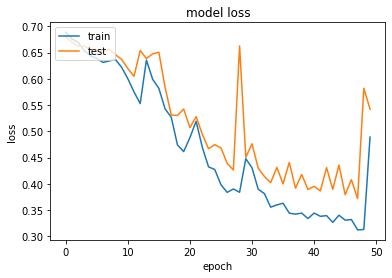

In [ ]:
# plot training history
import matplotlib.pyplot as plt
# summarize history for accuracy
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# calculate accuracy
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred = model(X_test)
print(y_pred)

tf.Tensor(
[[4.8879458e-05]
 [5.0276834e-01]
 [6.0129642e-01]
 [3.5249523e-03]
 [4.0321651e-01]
 [3.7864694e-01]
 [9.1570163e-01]
 [6.0250741e-01]
 [4.1553476e-01]
 [5.4462671e-02]
 [1.2308230e-03]
 [3.2469495e-03]
 [3.3688933e-01]
 [3.0290415e-03]
 [9.2391473e-01]
 [6.4816010e-01]
 [8.4841722e-01]
 [9.9702829e-01]
 [3.7974483e-01]], shape=(19, 1), dtype=float32)


In [ ]:
y_pred = [1 if y>0.5 else 0 for y in y_pred]
acc = (y_pred == Y_test).sum()/len(Y_test)
print(acc)

0.3684210526315789


In [ ]:
x_test.shape

(19, 7, 9988, 48)

In [ ]:
X_train[10, 80]

-3.0792

In [ ]:
x_train[1, 0, 8000, 0]

-3.0792

In [ ]:
X_train.shape

(440, 99)

In [ ]:
y_train[10:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
def defLSTM():
    # define model
    model = Sequential()
    model.add(LSTM(500, input_shape= (99, 1)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def myFit(m, X_train, Y_train, s):
    idx = list(range(0, Y_train.shape[0]))
    random.seed(s)
    random.shuffle(idx)
    X_train, Y_train = X_train[idx], Y_train[idx]
    train_X, val_X = X_train[:300].copy(), X_train[300:].copy()
    train_Y, val_Y = Y_train[:300].copy(), Y_train[300:].copy()
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
    val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
    hist = m.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))
    return hist, m


def evaluate(model, X_test, Y_test):
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model(X_test)
    y_pred = [1 if y>0.5 else 0 for y in y_pred]
    acc = (y_pred == Y_test).sum()/len(Y_test)
    return acc


def train(data, Y):
    # split training and test data set
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=10, stratify=Y)

    rslt = np.zeros((7, 48))

    for e in range(7):          # the time of experiments
        for v in tqdm(range(48)):     # the number of variable to be use in training
            X_train, Y_train = OneVar1Exp(x_train, y_train, 10, 100, e, v)
            X_test, Y_test = OneVar1Exp4test(x_test, y_test, 100, e, v)
            accs = list()
            for i in range(10): # train 10 times and calculate the average of accuracies
                model = defLSTM()
                hist, model = myFit(model, X_train, Y_train, i)
                acc = evaluate(model, X_test, Y_test)
                accs.append(acc)
            acc_mean = sum(accs)/len(accs)
            rslt[e, v] = acc_mean
            print(e, v, acc_mean)
        np.save('/content/gdrive/MyDrive/PhD/Hand/Data' + 'simplstm_rslt', rslt)


In [ ]:
train(data, Y)

  2%|▏         | 1/48 [02:13<1:44:30, 133.42s/it]

0 0 0.5842105263157895


  4%|▍         | 2/48 [04:17<1:37:53, 127.68s/it]

0 1 0.5684210526315789


  6%|▋         | 3/48 [06:21<1:34:30, 126.01s/it]

0 2 0.5052631578947369


  8%|▊         | 4/48 [08:25<1:31:49, 125.21s/it]

0 3 0.47894736842105257


 10%|█         | 5/48 [10:28<1:29:22, 124.72s/it]

0 4 0.5263157894736842


 12%|█▎        | 6/48 [12:32<1:27:04, 124.39s/it]

0 5 0.47894736842105257


 15%|█▍        | 7/48 [14:36<1:24:52, 124.22s/it]

0 6 0.5052631578947369


 17%|█▋        | 8/48 [16:40<1:22:44, 124.11s/it]

0 7 0.4894736842105263


 19%|█▉        | 9/48 [18:43<1:20:33, 123.94s/it]

0 8 0.4999999999999999


 21%|██        | 10/48 [20:47<1:18:27, 123.89s/it]

0 9 0.5263157894736841


 23%|██▎       | 11/48 [22:51<1:16:20, 123.79s/it]

0 10 0.5578947368421053


 25%|██▌       | 12/48 [24:55<1:14:18, 123.83s/it]

0 11 0.5578947368421053


 27%|██▋       | 13/48 [26:59<1:12:13, 123.81s/it]

0 12 0.5894736842105264


 29%|██▉       | 14/48 [29:03<1:10:11, 123.88s/it]

0 13 0.5684210526315789


 31%|███▏      | 15/48 [31:06<1:08:04, 123.78s/it]

0 14 0.5263157894736843


 33%|███▎      | 16/48 [33:10<1:06:02, 123.83s/it]

0 15 0.46315789473684205


 35%|███▌      | 17/48 [35:14<1:03:56, 123.74s/it]

0 16 0.42631578947368415


 38%|███▊      | 18/48 [37:17<1:01:50, 123.67s/it]

0 17 0.4526315789473684


 40%|███▉      | 19/48 [39:21<59:47, 123.70s/it]  

0 18 0.4999999999999999


 42%|████▏     | 20/48 [41:25<57:44, 123.73s/it]

0 19 0.4947368421052631


 44%|████▍     | 21/48 [43:29<55:42, 123.81s/it]

0 20 0.5052631578947369


 46%|████▌     | 22/48 [45:32<53:35, 123.69s/it]

0 21 0.5578947368421053


 48%|████▊     | 23/48 [47:36<51:31, 123.67s/it]

0 22 0.5894736842105264


 50%|█████     | 24/48 [49:39<49:26, 123.62s/it]

0 23 0.531578947368421


 52%|█████▏    | 25/48 [51:43<47:26, 123.75s/it]

0 24 0.6157894736842106


 54%|█████▍    | 26/48 [53:47<45:20, 123.65s/it]

0 25 0.4789473684210527


 56%|█████▋    | 27/48 [55:51<43:19, 123.80s/it]

0 26 0.5052631578947369


 58%|█████▊    | 28/48 [57:55<41:16, 123.82s/it]

0 27 0.4842105263157895


 60%|██████    | 29/48 [59:58<39:11, 123.74s/it]

0 28 0.46842105263157896


 62%|██████▎   | 30/48 [1:02:02<37:07, 123.77s/it]

0 29 0.48421052631578937


 65%|██████▍   | 31/48 [1:04:06<35:02, 123.69s/it]

0 30 0.4947368421052632


 67%|██████▋   | 32/48 [1:06:09<32:57, 123.62s/it]

0 31 0.4842105263157895


 69%|██████▉   | 33/48 [1:08:13<30:55, 123.71s/it]

0 32 0.4999999999999999


 71%|███████   | 34/48 [1:10:17<28:51, 123.66s/it]

0 33 0.5263157894736842


 73%|███████▎  | 35/48 [1:12:20<26:48, 123.71s/it]

0 34 0.5105263157894736


 75%|███████▌  | 36/48 [1:14:24<24:44, 123.71s/it]

0 35 0.5368421052631579


 77%|███████▋  | 37/48 [1:16:28<22:42, 123.89s/it]

0 36 0.6


 79%|███████▉  | 38/48 [1:18:32<20:38, 123.86s/it]

0 37 0.5210526315789472


 81%|████████▏ | 39/48 [1:20:36<18:34, 123.86s/it]

0 38 0.45789473684210513


 83%|████████▎ | 40/48 [1:22:50<16:55, 126.99s/it]

0 39 0.4473684210526316


 85%|████████▌ | 41/48 [1:24:56<14:45, 126.47s/it]

0 40 0.4947368421052631


 88%|████████▊ | 42/48 [1:27:00<12:34, 125.80s/it]

0 41 0.5473684210526316


 90%|████████▉ | 43/48 [1:29:04<10:26, 125.20s/it]

0 42 0.5105263157894736


 92%|█████████▏| 44/48 [1:31:07<08:18, 124.74s/it]

0 43 0.5052631578947369


 94%|█████████▍| 45/48 [1:33:12<06:14, 124.74s/it]

0 44 0.5052631578947369


 96%|█████████▌| 46/48 [1:35:16<04:09, 124.62s/it]

0 45 0.5578947368421052


 98%|█████████▊| 47/48 [1:37:20<02:04, 124.45s/it]

0 46 0.5263157894736842


100%|██████████| 48/48 [1:39:24<00:00, 124.27s/it]


0 47 0.5894736842105261


  2%|▏         | 1/48 [02:04<1:37:20, 124.27s/it]

1 0 0.6


  4%|▍         | 2/48 [04:18<1:39:40, 130.01s/it]

1 1 0.5631578947368421


  6%|▋         | 3/48 [06:22<1:35:29, 127.33s/it]

1 2 0.5421052631578948


  8%|▊         | 4/48 [08:26<1:32:23, 125.99s/it]

1 3 0.42105263157894735


 10%|█         | 5/48 [10:29<1:29:40, 125.14s/it]

1 4 0.5105263157894737


 12%|█▎        | 6/48 [12:33<1:27:16, 124.69s/it]

1 5 0.5


 15%|█▍        | 7/48 [14:38<1:25:07, 124.58s/it]

1 6 0.5052631578947369


 17%|█▋        | 8/48 [16:42<1:22:54, 124.35s/it]

1 7 0.4947368421052631


 19%|█▉        | 9/48 [18:45<1:20:39, 124.10s/it]

1 8 0.4999999999999999


 21%|██        | 10/48 [20:49<1:18:39, 124.19s/it]

1 9 0.5526315789473685


 23%|██▎       | 11/48 [22:53<1:16:30, 124.08s/it]

1 10 0.5315789473684209


 25%|██▌       | 12/48 [24:58<1:14:29, 124.15s/it]

1 11 0.5578947368421053


 27%|██▋       | 13/48 [27:02<1:12:24, 124.14s/it]

1 12 0.6052631578947368


 29%|██▉       | 14/48 [29:06<1:10:18, 124.08s/it]

1 13 0.5421052631578946


 31%|███▏      | 15/48 [31:10<1:08:14, 124.07s/it]

1 14 0.5210526315789474


 33%|███▎      | 16/48 [33:14<1:06:10, 124.08s/it]

1 15 0.36842105263157887


 35%|███▌      | 17/48 [35:18<1:04:05, 124.06s/it]

1 16 0.42631578947368426


 38%|███▊      | 18/48 [37:22<1:02:01, 124.06s/it]

1 17 0.46842105263157896


 40%|███▉      | 19/48 [39:26<59:59, 124.11s/it]  

1 18 0.4947368421052631


 42%|████▏     | 20/48 [41:30<57:52, 124.01s/it]

1 19 0.4947368421052631


 44%|████▍     | 21/48 [43:34<55:45, 123.89s/it]

1 20 0.4999999999999999


 46%|████▌     | 22/48 [45:38<53:46, 124.09s/it]

1 21 0.5421052631578948


 48%|████▊     | 23/48 [47:42<51:40, 124.02s/it]

1 22 0.5736842105263158


 50%|█████     | 24/48 [49:46<49:35, 123.96s/it]

1 23 0.5526315789473685


 52%|█████▏    | 25/48 [51:50<47:33, 124.08s/it]

1 24 0.6526315789473683


 54%|█████▍    | 26/48 [53:54<45:27, 123.96s/it]

1 25 0.4894736842105264


 56%|█████▋    | 27/48 [55:58<43:24, 124.04s/it]

1 26 0.4842105263157895


 58%|█████▊    | 28/48 [58:02<41:21, 124.05s/it]

1 27 0.41052631578947363


 60%|██████    | 29/48 [1:00:06<39:14, 123.94s/it]

1 28 0.48421052631578937


 62%|██████▎   | 30/48 [1:02:10<37:10, 123.94s/it]

1 29 0.5


 65%|██████▍   | 31/48 [1:04:14<35:07, 123.97s/it]

1 30 0.4947368421052631


 67%|██████▋   | 32/48 [1:06:17<33:02, 123.88s/it]

1 31 0.4894736842105263


 69%|██████▉   | 33/48 [1:08:21<30:58, 123.91s/it]

1 32 0.4999999999999999


 71%|███████   | 34/48 [1:10:25<28:54, 123.88s/it]

1 33 0.5473684210526315


 73%|███████▎  | 35/48 [1:12:30<26:53, 124.10s/it]

1 34 0.531578947368421


 75%|███████▌  | 36/48 [1:14:34<24:48, 124.07s/it]

1 35 0.5210526315789474


 77%|███████▋  | 37/48 [1:16:38<22:46, 124.24s/it]

1 36 0.6473684210526316


 79%|███████▉  | 38/48 [1:18:42<20:40, 124.04s/it]

1 37 0.5947368421052632


 81%|████████▏ | 39/48 [1:20:55<19:01, 126.86s/it]

1 38 0.5052631578947369


 83%|████████▎ | 40/48 [1:23:00<16:49, 126.13s/it]

1 39 0.46842105263157896


 85%|████████▌ | 41/48 [1:25:04<14:37, 125.38s/it]

1 40 0.4947368421052631


 88%|████████▊ | 42/48 [1:27:07<12:29, 124.90s/it]

1 41 0.5105263157894737


 90%|████████▉ | 43/48 [1:29:11<10:22, 124.51s/it]

1 42 0.4947368421052631


 92%|█████████▏| 44/48 [1:31:15<08:17, 124.43s/it]

1 43 0.5


 94%|█████████▍| 45/48 [1:33:19<06:12, 124.20s/it]

1 44 0.4999999999999999


 96%|█████████▌| 46/48 [1:35:23<04:08, 124.27s/it]

1 45 0.5473684210526315


 98%|█████████▊| 47/48 [1:37:27<02:04, 124.15s/it]

1 46 0.5789473684210525


100%|██████████| 48/48 [1:39:32<00:00, 124.42s/it]


1 47 0.5631578947368421


  2%|▏         | 1/48 [02:04<1:37:30, 124.47s/it]

2 0 0.5789473684210527


  4%|▍         | 2/48 [04:08<1:35:16, 124.26s/it]

2 1 0.5210526315789474


  6%|▋         | 3/48 [06:13<1:33:18, 124.40s/it]

2 2 0.5578947368421053


  8%|▊         | 4/48 [08:17<1:31:12, 124.37s/it]

2 3 0.42105263157894735


 10%|█         | 5/48 [10:21<1:29:07, 124.35s/it]

2 4 0.5105263157894736


 12%|█▎        | 6/48 [12:26<1:27:03, 124.37s/it]

2 5 0.5052631578947369


 15%|█▍        | 7/48 [14:29<1:24:50, 124.15s/it]

2 6 0.5


 17%|█▋        | 8/48 [16:34<1:22:48, 124.21s/it]

2 7 0.4947368421052631


 19%|█▉        | 9/48 [18:38<1:20:41, 124.13s/it]

2 8 0.4947368421052631


 21%|██        | 10/48 [20:42<1:18:37, 124.15s/it]

2 9 0.5631578947368421


 23%|██▎       | 11/48 [22:46<1:16:37, 124.27s/it]

2 10 0.5684210526315789


 25%|██▌       | 12/48 [24:51<1:14:31, 124.21s/it]

2 11 0.5368421052631579


 27%|██▋       | 13/48 [26:55<1:12:26, 124.20s/it]

2 12 0.5736842105263158


 29%|██▉       | 14/48 [28:59<1:10:20, 124.13s/it]

2 13 0.5473684210526316


 31%|███▏      | 15/48 [31:03<1:08:15, 124.12s/it]

2 14 0.5473684210526315


 33%|███▎      | 16/48 [33:07<1:06:12, 124.13s/it]

2 15 0.3578947368421052


 35%|███▌      | 17/48 [35:11<1:04:07, 124.12s/it]

2 16 0.42631578947368415


 38%|███▊      | 18/48 [37:18<1:02:30, 125.00s/it]

2 17 0.4947368421052631


 40%|███▉      | 19/48 [39:28<1:01:06, 126.41s/it]

2 18 0.4999999999999999


 42%|████▏     | 20/48 [41:39<59:36, 127.72s/it]  

2 19 0.4894736842105263


 44%|████▍     | 21/48 [43:48<57:46, 128.38s/it]

2 20 0.46315789473684205


 46%|████▌     | 22/48 [45:59<55:52, 128.94s/it]

2 21 0.5157894736842105


 48%|████▊     | 23/48 [48:09<53:50, 129.23s/it]

2 22 0.5684210526315789


 50%|█████     | 24/48 [50:18<51:45, 129.40s/it]

2 23 0.5684210526315789


 52%|█████▏    | 25/48 [52:38<50:46, 132.46s/it]

2 24 0.6210526315789474


 54%|█████▍    | 26/48 [54:48<48:15, 131.62s/it]

2 25 0.4894736842105263


 56%|█████▋    | 27/48 [56:58<45:55, 131.21s/it]

2 26 0.4526315789473684


 58%|█████▊    | 28/48 [59:08<43:35, 130.78s/it]

2 27 0.43684210526315786


 60%|██████    | 29/48 [1:01:17<41:17, 130.41s/it]

2 28 0.46842105263157885


 62%|██████▎   | 30/48 [1:03:27<39:02, 130.15s/it]

2 29 0.4842105263157895


 65%|██████▍   | 31/48 [1:05:36<36:48, 129.91s/it]

2 30 0.4947368421052631


 67%|██████▋   | 32/48 [1:07:46<34:36, 129.81s/it]

2 31 0.43684210526315786


 69%|██████▉   | 33/48 [1:09:55<32:25, 129.73s/it]

2 32 0.4947368421052631


 71%|███████   | 34/48 [1:12:05<30:15, 129.65s/it]

2 33 0.5473684210526317


 73%|███████▎  | 35/48 [1:14:14<28:04, 129.59s/it]

2 34 0.5894736842105264


 75%|███████▌  | 36/48 [1:16:24<25:55, 129.61s/it]

2 35 0.5421052631578946


 77%|███████▋  | 37/48 [1:18:34<23:47, 129.81s/it]

2 36 0.6210526315789474


 79%|███████▉  | 38/48 [1:20:44<21:37, 129.79s/it]

2 37 0.5526315789473684


 81%|████████▏ | 39/48 [1:22:54<19:27, 129.76s/it]

2 38 0.5105263157894736


 83%|████████▎ | 40/48 [1:25:04<17:18, 129.86s/it]

2 39 0.4052631578947368


 85%|████████▌ | 41/48 [1:27:13<15:08, 129.74s/it]

2 40 0.43684210526315786


 88%|████████▊ | 42/48 [1:29:23<12:58, 129.71s/it]

2 41 0.46315789473684205


 90%|████████▉ | 43/48 [1:31:33<10:49, 129.91s/it]

2 42 0.4947368421052631


 92%|█████████▏| 44/48 [1:33:52<08:50, 132.63s/it]

2 43 0.4789473684210527


 94%|█████████▍| 45/48 [1:36:02<06:35, 131.88s/it]

2 44 0.48421052631578937


 96%|█████████▌| 46/48 [1:38:12<04:22, 131.27s/it]

2 45 0.5578947368421053


 98%|█████████▊| 47/48 [1:40:22<02:10, 130.84s/it]

2 46 0.5842105263157895


100%|██████████| 48/48 [1:42:32<00:00, 128.18s/it]


2 47 0.5421052631578946


  2%|▏         | 1/48 [02:10<1:42:27, 130.80s/it]

3 0 0.6105263157894736


  4%|▍         | 2/48 [04:21<1:40:17, 130.81s/it]

3 1 0.5421052631578946


  6%|▋         | 3/48 [06:31<1:37:57, 130.60s/it]

3 2 0.5157894736842105


  8%|▊         | 4/48 [08:41<1:35:36, 130.37s/it]

3 3 0.42105263157894735


 10%|█         | 5/48 [10:51<1:33:16, 130.16s/it]

3 4 0.46842105263157896


 12%|█▎        | 6/48 [13:03<1:31:27, 130.65s/it]

3 5 0.531578947368421


 15%|█▍        | 7/48 [15:14<1:29:22, 130.80s/it]

3 6 0.4947368421052631


 17%|█▋        | 8/48 [17:25<1:27:09, 130.74s/it]

3 7 0.5105263157894736


 19%|█▉        | 9/48 [19:36<1:25:01, 130.81s/it]

3 8 0.4894736842105263


 21%|██        | 10/48 [21:47<1:22:55, 130.95s/it]

3 9 0.5157894736842106


 23%|██▎       | 11/48 [23:58<1:20:42, 130.87s/it]

3 10 0.5263157894736843


 25%|██▌       | 12/48 [26:08<1:18:25, 130.70s/it]

3 11 0.5473684210526317


 27%|██▋       | 13/48 [28:18<1:16:06, 130.48s/it]

3 12 0.5421052631578948


 29%|██▉       | 14/48 [30:28<1:13:54, 130.42s/it]

3 13 0.5052631578947369


 31%|███▏      | 15/48 [32:38<1:11:40, 130.33s/it]

3 14 0.5578947368421053


 33%|███▎      | 16/48 [34:48<1:09:28, 130.28s/it]

3 15 0.3999999999999999


 35%|███▌      | 17/48 [36:58<1:07:15, 130.17s/it]

3 16 0.47368421052631576


 38%|███▊      | 18/48 [39:08<1:05:04, 130.14s/it]

3 17 0.5210526315789473


 40%|███▉      | 19/48 [41:18<1:02:52, 130.09s/it]

3 18 0.4999999999999999


 42%|████▏     | 20/48 [43:28<1:00:40, 130.01s/it]

3 19 0.4947368421052632


 44%|████▍     | 21/48 [45:38<58:30, 130.01s/it]  

3 20 0.47368421052631576


 46%|████▌     | 22/48 [47:48<56:18, 129.96s/it]

3 21 0.5473684210526317


 48%|████▊     | 23/48 [49:58<54:06, 129.88s/it]

3 22 0.6


 50%|█████     | 24/48 [52:07<51:56, 129.85s/it]

3 23 0.5526315789473685


 52%|█████▏    | 25/48 [54:17<49:45, 129.83s/it]

3 24 0.6421052631578946


 54%|█████▍    | 26/48 [56:27<47:36, 129.84s/it]

3 25 0.46315789473684205


 56%|█████▋    | 27/48 [58:37<45:28, 129.91s/it]

3 26 0.4368421052631578


 58%|█████▊    | 28/48 [1:00:47<43:19, 130.00s/it]

3 27 0.42631578947368426


 60%|██████    | 29/48 [1:02:57<41:10, 130.01s/it]

3 28 0.5052631578947369


 62%|██████▎   | 30/48 [1:05:07<39:00, 130.01s/it]

3 29 0.5052631578947369


 65%|██████▍   | 31/48 [1:07:17<36:49, 129.99s/it]

3 30 0.5052631578947369


 67%|██████▋   | 32/48 [1:09:27<34:39, 129.94s/it]

3 31 0.5


 69%|██████▉   | 33/48 [1:11:37<32:30, 130.02s/it]

3 32 0.4947368421052631


 71%|███████   | 34/48 [1:13:47<30:16, 129.76s/it]

3 33 0.5421052631578946


 73%|███████▎  | 35/48 [1:15:56<28:07, 129.77s/it]

3 34 0.6


 75%|███████▌  | 36/48 [1:18:06<25:57, 129.76s/it]

3 35 0.5526315789473685


 77%|███████▋  | 37/48 [1:20:16<23:47, 129.74s/it]

3 36 0.6684210526315789


 79%|███████▉  | 38/48 [1:22:26<21:38, 129.84s/it]

3 37 0.5052631578947369


 81%|████████▏ | 39/48 [1:24:36<19:28, 129.88s/it]

3 38 0.4894736842105264


 83%|████████▎ | 40/48 [1:26:44<17:15, 129.49s/it]

3 39 0.531578947368421


 85%|████████▌ | 41/48 [1:28:52<15:01, 128.77s/it]

3 40 0.5105263157894736


 88%|████████▊ | 42/48 [1:30:59<12:51, 128.50s/it]

3 41 0.5368421052631579


 90%|████████▉ | 43/48 [1:33:08<10:42, 128.55s/it]

3 42 0.4999999999999999


 92%|█████████▏| 44/48 [1:35:17<08:34, 128.73s/it]

3 43 0.4999999999999999


 94%|█████████▍| 45/48 [1:37:26<06:26, 128.81s/it]

3 44 0.4999999999999999


 96%|█████████▌| 46/48 [1:39:36<04:18, 129.09s/it]

3 45 0.531578947368421


 98%|█████████▊| 47/48 [1:41:47<02:09, 129.71s/it]

3 46 0.5789473684210525


100%|██████████| 48/48 [1:44:00<00:00, 130.00s/it]


3 47 0.5473684210526317


  2%|▏         | 1/48 [02:11<1:42:59, 131.48s/it]

4 0 0.5842105263157895


  4%|▍         | 2/48 [04:23<1:40:51, 131.55s/it]

4 1 0.5421052631578946


  6%|▋         | 3/48 [06:34<1:38:27, 131.28s/it]

4 2 0.47894736842105257


  8%|▊         | 4/48 [08:44<1:36:09, 131.11s/it]

4 3 0.4526315789473684


 10%|█         | 5/48 [10:56<1:33:58, 131.13s/it]

4 4 0.38421052631578945


 12%|█▎        | 6/48 [13:07<1:31:52, 131.25s/it]

4 5 0.46842105263157896


 15%|█▍        | 7/48 [15:17<1:29:25, 130.87s/it]

4 6 0.4999999999999999


 17%|█▋        | 8/48 [17:27<1:26:59, 130.48s/it]

4 7 0.4999999999999999


 19%|█▉        | 9/48 [19:37<1:24:43, 130.34s/it]

4 8 0.4999999999999999


 21%|██        | 10/48 [21:47<1:22:25, 130.14s/it]

4 9 0.5421052631578946


 23%|██▎       | 11/48 [23:56<1:20:13, 130.09s/it]

4 10 0.5526315789473684


 25%|██▌       | 12/48 [26:06<1:17:59, 129.99s/it]

4 11 0.531578947368421


 27%|██▋       | 13/48 [28:16<1:15:52, 130.07s/it]

4 12 0.5789473684210525


 29%|██▉       | 14/48 [30:25<1:13:26, 129.59s/it]

4 13 0.4894736842105263


 31%|███▏      | 15/48 [32:33<1:10:57, 129.02s/it]

4 14 0.5368421052631579


 33%|███▎      | 16/48 [34:42<1:08:53, 129.18s/it]

4 15 0.531578947368421


 35%|███▌      | 17/48 [36:52<1:06:50, 129.36s/it]

4 16 0.5157894736842106


 38%|███▊      | 18/48 [39:02<1:04:45, 129.51s/it]

4 17 0.5210526315789472


 40%|███▉      | 19/48 [41:13<1:02:47, 129.92s/it]

4 18 0.5105263157894736


 42%|████▏     | 20/48 [43:24<1:00:45, 130.19s/it]

4 19 0.4999999999999999


 44%|████▍     | 21/48 [45:35<58:41, 130.43s/it]  

4 20 0.4947368421052632


 46%|████▌     | 22/48 [47:46<56:37, 130.66s/it]

4 21 0.5526315789473684


 48%|████▊     | 23/48 [49:57<54:30, 130.82s/it]

4 22 0.5368421052631578


 50%|█████     | 24/48 [52:07<52:14, 130.59s/it]

4 23 0.5526315789473684


 52%|█████▏    | 25/48 [54:17<49:59, 130.40s/it]

4 24 0.5684210526315789


 54%|█████▍    | 26/48 [56:27<47:45, 130.24s/it]

4 25 0.4894736842105264


 56%|█████▋    | 27/48 [58:36<45:30, 130.01s/it]

4 26 0.5210526315789474


 58%|█████▊    | 28/48 [1:00:46<43:19, 129.99s/it]

4 27 0.5578947368421052


 60%|██████    | 29/48 [1:02:57<41:12, 130.11s/it]

4 28 0.4947368421052631


 62%|██████▎   | 30/48 [1:05:07<39:02, 130.14s/it]

4 29 0.5157894736842106


 65%|██████▍   | 31/48 [1:07:17<36:53, 130.20s/it]

4 30 0.5052631578947369


 67%|██████▋   | 32/48 [1:09:28<34:47, 130.47s/it]

4 31 0.4999999999999999


 69%|██████▉   | 33/48 [1:11:39<32:38, 130.59s/it]

4 32 0.4894736842105263


 71%|███████   | 34/48 [1:13:51<30:33, 130.93s/it]

4 33 0.5210526315789472


 73%|███████▎  | 35/48 [1:16:02<28:24, 131.12s/it]

4 34 0.5789473684210525


 75%|███████▌  | 36/48 [1:18:13<26:11, 131.00s/it]

4 35 0.5473684210526315


 77%|███████▋  | 37/48 [1:20:24<24:00, 130.93s/it]

4 36 0.5578947368421052


 79%|███████▉  | 38/48 [1:22:36<21:51, 131.15s/it]

4 37 0.5263157894736842


 81%|████████▏ | 39/48 [1:24:45<19:36, 130.69s/it]

4 38 0.5


 83%|████████▎ | 40/48 [1:26:55<17:22, 130.37s/it]

4 39 0.536842105263158


 85%|████████▌ | 41/48 [1:29:04<15:10, 130.13s/it]

4 40 0.5052631578947369


 88%|████████▊ | 42/48 [1:31:13<12:58, 129.69s/it]

4 41 0.47368421052631576


 90%|████████▉ | 43/48 [1:33:21<10:46, 129.26s/it]

4 42 0.4999999999999999


 92%|█████████▏| 44/48 [1:35:29<08:35, 128.90s/it]

4 43 0.47368421052631576


 94%|█████████▍| 45/48 [1:37:39<06:27, 129.24s/it]

4 44 0.4999999999999999


 96%|█████████▌| 46/48 [1:39:49<04:18, 129.50s/it]

4 45 0.5263157894736843


 98%|█████████▊| 47/48 [1:41:59<02:09, 129.59s/it]

4 46 0.5736842105263158


100%|██████████| 48/48 [1:44:08<00:00, 130.19s/it]


4 47 0.5421052631578946


  2%|▏         | 1/48 [02:09<1:41:06, 129.08s/it]

5 0 0.5842105263157895


  4%|▍         | 2/48 [04:16<1:38:23, 128.33s/it]

5 1 0.5210526315789473


  6%|▋         | 3/48 [06:24<1:36:09, 128.22s/it]

5 2 0.4842105263157895


  8%|▊         | 4/48 [08:32<1:33:53, 128.03s/it]

5 3 0.47894736842105257


 10%|█         | 5/48 [10:40<1:31:43, 127.99s/it]

5 4 0.46842105263157885


 12%|█▎        | 6/48 [12:48<1:29:34, 127.96s/it]

5 5 0.47894736842105257


 15%|█▍        | 7/48 [14:56<1:27:20, 127.81s/it]

5 6 0.5052631578947369


 17%|█▋        | 8/48 [17:03<1:25:09, 127.73s/it]

5 7 0.4894736842105263


 19%|█▉        | 9/48 [19:11<1:23:03, 127.78s/it]

5 8 0.4999999999999999


 21%|██        | 10/48 [21:19<1:20:59, 127.88s/it]

5 9 0.5421052631578946


 23%|██▎       | 11/48 [23:28<1:19:05, 128.26s/it]

5 10 0.5684210526315789


 25%|██▌       | 12/48 [25:38<1:17:09, 128.60s/it]

5 11 0.5421052631578946


 27%|██▋       | 13/48 [27:47<1:15:09, 128.84s/it]

5 12 0.5578947368421052


 29%|██▉       | 14/48 [29:56<1:13:03, 128.92s/it]

5 13 0.5526315789473684


 31%|███▏      | 15/48 [32:04<1:10:41, 128.53s/it]

5 14 0.5631578947368421


 33%|███▎      | 16/48 [34:11<1:08:24, 128.28s/it]

5 15 0.4631578947368421


 35%|███▌      | 17/48 [36:19<1:06:13, 128.17s/it]

5 16 0.5


 38%|███▊      | 18/48 [38:26<1:03:55, 127.86s/it]

5 17 0.4947368421052631


 40%|███▉      | 19/48 [40:32<1:01:32, 127.32s/it]

5 18 0.4947368421052631


 42%|████▏     | 20/48 [42:38<59:09, 126.78s/it]  

5 19 0.4842105263157895


 44%|████▍     | 21/48 [44:44<56:56, 126.55s/it]

5 20 0.4999999999999999


 46%|████▌     | 22/48 [46:50<54:48, 126.49s/it]

5 21 0.5473684210526316


 48%|████▊     | 23/48 [48:57<52:39, 126.39s/it]

5 22 0.5631578947368421


 50%|█████     | 24/48 [51:02<50:29, 126.22s/it]

5 23 0.5052631578947369


 52%|█████▏    | 25/48 [53:09<48:29, 126.48s/it]

5 24 0.6210526315789474


 54%|█████▍    | 26/48 [55:19<46:41, 127.33s/it]

5 25 0.4842105263157895


 56%|█████▋    | 27/48 [57:28<44:48, 128.04s/it]

5 26 0.4473684210526315


 58%|█████▊    | 28/48 [59:38<42:49, 128.48s/it]

5 27 0.5157894736842106


 60%|██████    | 29/48 [1:01:47<40:46, 128.78s/it]

5 28 0.47894736842105257


 62%|██████▎   | 30/48 [1:03:57<38:41, 128.95s/it]

5 29 0.4947368421052631


 65%|██████▍   | 31/48 [1:06:04<36:24, 128.49s/it]

5 30 0.5052631578947369


 67%|██████▋   | 32/48 [1:08:12<34:12, 128.31s/it]

5 31 0.4947368421052631


 69%|██████▉   | 33/48 [1:10:22<32:09, 128.66s/it]

5 32 0.5000000000000001


 71%|███████   | 34/48 [1:12:31<30:05, 128.98s/it]

5 33 0.5526315789473685


 73%|███████▎  | 35/48 [1:14:41<27:59, 129.20s/it]

5 34 0.5842105263157894


 75%|███████▌  | 36/48 [1:16:50<25:50, 129.24s/it]

5 35 0.5578947368421053


 77%|███████▋  | 37/48 [1:19:00<23:42, 129.36s/it]

5 36 0.6052631578947368


 79%|███████▉  | 38/48 [1:21:10<21:35, 129.59s/it]

5 37 0.4631578947368421


 81%|████████▏ | 39/48 [1:23:22<19:33, 130.35s/it]

5 38 0.4947368421052632


 83%|████████▎ | 40/48 [1:25:32<17:20, 130.05s/it]

5 39 0.46842105263157896


 85%|████████▌ | 41/48 [1:27:41<15:09, 129.94s/it]

5 40 0.4842105263157895


 88%|████████▊ | 42/48 [1:29:51<12:58, 129.83s/it]

5 41 0.5105263157894736


 90%|████████▉ | 43/48 [1:32:02<10:51, 130.30s/it]

5 42 0.5052631578947369


 92%|█████████▏| 44/48 [1:34:13<08:41, 130.39s/it]

5 43 0.48421052631578937


 94%|█████████▍| 45/48 [1:36:25<06:32, 130.91s/it]

5 44 0.4631578947368421


 96%|█████████▌| 46/48 [1:38:37<04:22, 131.31s/it]

5 45 0.531578947368421


 98%|█████████▊| 47/48 [1:40:50<02:11, 131.62s/it]

5 46 0.5684210526315789


100%|██████████| 48/48 [1:43:01<00:00, 128.78s/it]


5 47 0.5684210526315789


  2%|▏         | 1/48 [02:11<1:43:11, 131.73s/it]

6 0 0.5894736842105263


  4%|▍         | 2/48 [04:24<1:41:22, 132.24s/it]

6 1 0.6


  6%|▋         | 3/48 [06:35<1:38:40, 131.57s/it]

6 2 0.4947368421052631


  8%|▊         | 4/48 [08:43<1:35:31, 130.27s/it]

6 3 0.531578947368421


 10%|█         | 5/48 [10:53<1:33:17, 130.17s/it]

6 4 0.48421052631578937


 12%|█▎        | 6/48 [13:02<1:30:53, 129.85s/it]

6 5 0.5052631578947369


 15%|█▍        | 7/48 [15:12<1:28:39, 129.75s/it]

6 6 0.5052631578947369


 17%|█▋        | 8/48 [17:20<1:26:16, 129.41s/it]

6 7 0.4894736842105263


 19%|█▉        | 9/48 [19:30<1:24:11, 129.51s/it]

6 8 0.4894736842105263


 21%|██        | 10/48 [21:43<1:22:39, 130.51s/it]

6 9 0.531578947368421


 23%|██▎       | 11/48 [23:53<1:20:22, 130.33s/it]

6 10 0.5684210526315789


 25%|██▌       | 12/48 [26:04<1:18:26, 130.72s/it]

6 11 0.5473684210526315


 27%|██▋       | 13/48 [28:14<1:16:05, 130.45s/it]

6 12 0.5526315789473684


 29%|██▉       | 14/48 [30:26<1:14:12, 130.97s/it]

6 13 0.5210526315789474


 31%|███▏      | 15/48 [32:35<1:11:40, 130.31s/it]

6 14 0.531578947368421


 33%|███▎      | 16/48 [34:45<1:09:22, 130.09s/it]

6 15 0.45263157894736833


 35%|███▌      | 17/48 [36:54<1:07:07, 129.93s/it]

6 16 0.5157894736842105


 38%|███▊      | 18/48 [39:04<1:04:53, 129.78s/it]

6 17 0.5


 40%|███▉      | 19/48 [41:12<1:02:34, 129.48s/it]

6 18 0.4999999999999999


 42%|████▏     | 20/48 [43:24<1:00:46, 130.24s/it]

6 19 0.5052631578947369


 44%|████▍     | 21/48 [45:35<58:40, 130.38s/it]  

6 20 0.4999999999999999


 46%|████▌     | 22/48 [47:44<56:17, 129.90s/it]

6 21 0.5263157894736843


 48%|████▊     | 23/48 [49:53<54:04, 129.79s/it]

6 22 0.5368421052631579


 50%|█████     | 24/48 [52:03<51:54, 129.76s/it]

6 23 0.5526315789473684


 52%|█████▏    | 25/48 [54:14<49:48, 129.95s/it]

6 24 0.5947368421052632


 54%|█████▍    | 26/48 [56:26<47:56, 130.74s/it]

6 25 0.4894736842105263


 56%|█████▋    | 27/48 [58:36<45:40, 130.49s/it]

6 26 0.4631578947368421


 58%|█████▊    | 28/48 [1:00:45<43:21, 130.08s/it]

6 27 0.5736842105263158


 60%|██████    | 29/48 [1:02:54<41:05, 129.76s/it]

6 28 0.5105263157894736


 62%|██████▎   | 30/48 [1:05:03<38:48, 129.37s/it]

6 29 0.5052631578947369


 65%|██████▍   | 31/48 [1:07:14<36:47, 129.87s/it]

6 30 0.4947368421052631


 67%|██████▋   | 32/48 [1:09:26<34:47, 130.50s/it]

6 31 0.4947368421052631


 69%|██████▉   | 33/48 [1:11:37<32:40, 130.71s/it]

6 32 0.4999999999999999


 71%|███████   | 34/48 [1:13:47<30:27, 130.52s/it]

6 33 0.5736842105263158


 73%|███████▎  | 35/48 [1:15:57<28:14, 130.35s/it]

6 34 0.5894736842105264


 75%|███████▌  | 36/48 [1:18:05<25:57, 129.83s/it]

6 35 0.5473684210526317


 77%|███████▋  | 37/48 [1:20:15<23:47, 129.74s/it]

6 36 0.6631578947368421


 79%|███████▉  | 38/48 [1:22:28<21:47, 130.78s/it]

6 37 0.531578947368421


 81%|████████▏ | 39/48 [1:24:39<19:35, 130.63s/it]

6 38 0.4789473684210527


 83%|████████▎ | 40/48 [1:26:51<17:29, 131.13s/it]

6 39 0.5578947368421053


 85%|████████▌ | 41/48 [1:29:03<15:19, 131.30s/it]

6 40 0.5052631578947369


 88%|████████▊ | 42/48 [1:31:14<13:08, 131.47s/it]

6 41 0.4473684210526316


 90%|████████▉ | 43/48 [1:33:25<10:56, 131.27s/it]

6 42 0.5052631578947369


 92%|█████████▏| 44/48 [1:35:33<08:41, 130.28s/it]

6 43 0.48421052631578937


 94%|█████████▍| 45/48 [1:37:39<06:26, 128.93s/it]

6 44 0.5052631578947369


 96%|█████████▌| 46/48 [1:39:45<04:15, 127.98s/it]

6 45 0.5421052631578948


 98%|█████████▊| 47/48 [1:41:53<02:08, 128.12s/it]

6 46 0.5631578947368421


100%|██████████| 48/48 [1:43:59<00:00, 130.00s/it]

6 47 0.5578947368421053
